## Load modules
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)  
[#Link-with-orography?](#Link-with-orography?)  

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 232 GB / percent used: 7.6 %


## Load model data

In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'
var = 'snc'
if var in ['tas', 'pr']:
    table = 'Amon'
elif var in ['snc']:
    table = 'LImon'
    
var_label = 'Snow cover extent [%]'
var_label_trends = 'Snow cover extent trends [%/dec]'
var_label_bias = 'Snow cover bias [%]'
cmap='viridis'
levels=plot.arange(0,100,10)

# Load ensemble mean
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)  
[#Link-with-orography?](#Link-with-orography?) 

In [3]:
realization = 'ens'
# Load historical ens
experiment='historical'
da_historical = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
)

## Load obs

#### NOAA Climate Data Record (CDR) of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1
https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756

##### Test davos ou lapaz colormaps (with update)
ex: https://climate.rutgers.edu/snowcover/chart_vis.php?ui_year=2020&ui_month=1&ui_set=1

In [4]:
obs_longname = 'NOAA Climate Data Record (CDR) Version 1'
obs_name = 'NOAA CDR'

In [5]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
ds_rutger

<xarray.Dataset>
Dimensions:               (cols: 88, rows: 88, time: 1774)
Coordinates:
  * time                  (time) datetime64[ns] 1981-01-05 ... 2014-12-29
    snow_cover_threshold  float32 ...
    latitude              (rows, cols) float64 ...
    longitude             (rows, cols) float64 ...
Dimensions without coordinates: cols, rows
Data variables:
    coord_system          |S1 ...
    land                  (rows, cols) float32 ...
    area                  (rows, cols) float32 ...
    snow_cover_extent     (time, rows, cols) float32 ...
Attributes:
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, NOAA C...
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        nhsce_v01r01_19661004_20191202.nc
    naming_authority:          gov.noaa.ncdc
    metadata_link:             https://doi.org/10.7289/V5N014G9
    title:                     Climate Data Record (CDR) of Northern Hemisphe...
    product_version:           v01r01
    summary:                   The data record for the NH SCE CDR spans from ...
    keywords:                  EARTH SCIENCE > CRYOSPHERE > SNOW/ICE > SNOW C...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Ear...
    platform:                  ESSA, NOAA POES, SMS, DMSP, GOES, TIROS, METEO...
    sensor:                    VIDEO CAMERA, VISSR, VAS, VHRR, AVHRR, VISSR-G...
    cdm_data_type:             Grid
    cdr_program:               NOAA Climate Data Record Program for satellites
    cdr_variable:              snow_cover_extent
    source:                    NOAA NH Weekly SCE, NIC NH IMS SCE
    date_created:              2019-12-03T03:11:23Z
    institution:               Global Snow Lab, Center for Environmental Pred...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    geospatial_lat_min:        0.0
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    spatial_resolution:        Minimum cell area 10676.8 km^2, maximum cell a...
    time_coverage_start:       1966-10-04
    time_coverage_end:         2019-12-02
    license:                   No restrictions on access or use

##### Get the snc variable, keep only land data, convert to % and resample by months  
Resampling with xarray: http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html  
**Offset aliases**: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases  
Here we use: **MS**	month start frequency

In [6]:
# Get the snc variable, keep only land data and convert to %
with xr.set_options(keep_attrs=True):
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100
    
obs.attrs['units'] = '%'

# Rename lon and lat for the regrid
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna='False', keep_attrs=True)
obs

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'snow_cover_extent' (time: 408, rows: 88, cols: 88)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time                  (time) datetime64[ns] 1981-01-01 ... 2014-12-01
    snow_cover_threshold  float32 0.42
    lat                   (rows, cols) float64 0.6592 1.322 ... 1.322 0.6592
    lon                   (rows, cols) float64 145.0 144.3 ... -35.67 -35.0
Dimensions without coordinates: rows, cols
Attributes:
    long_name:      NOAA/NCDC Climate Data Record of snow cover extent
    standard_name:  surface_snow_binary_mask
    grid_mapping:   coord_system
    valid_range:    [0 1]
    flag_values:    [0 1]
    flag_meanings:  no_snow snow_covered
    units:          %

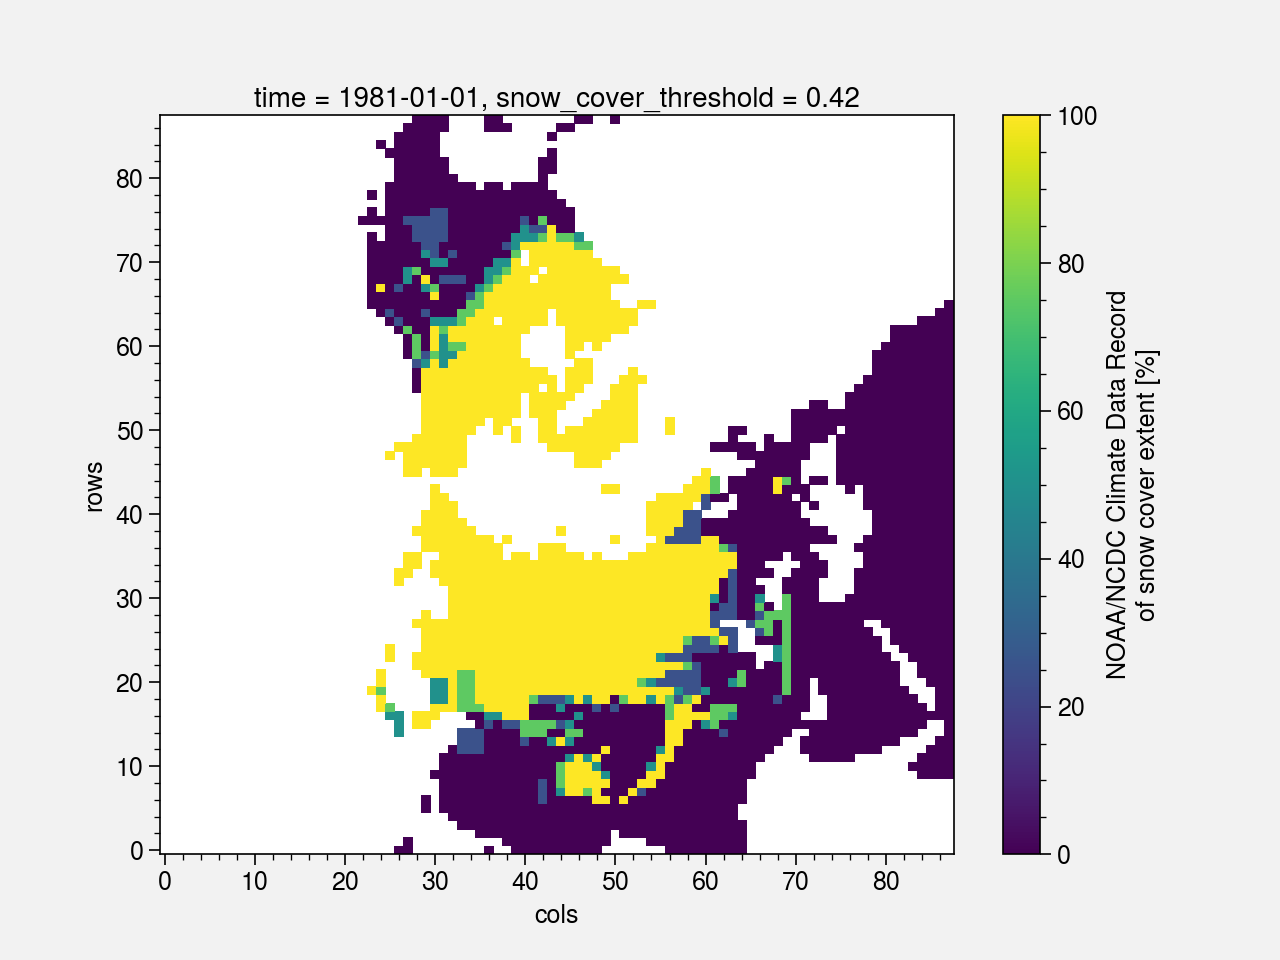

In [7]:
obs[0].plot()

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 
Value of cells in the new grid that are outside the old grid's domain #15 (https://github.com/JiaweiZhuang/xESMF/issues/15)

In [7]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

# Make the regrider
regridder_obs = xe.Regridder(obs, da_historical, 'bilinear', periodic=False)
regridder_obs = add_matrix_NaNs(regridder_obs)
print(regridder_obs)

# Regrid the data
obs_regrid = regridder_obs(obs)

Overwrite existing file: bilinear_88x88_143x144.nc 
 You can set reuse_weights=True to save computing time.


/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_88x88_143x144.nc 
Reuse pre-computed weights? False 
Input grid shape:           (88, 88) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False


Text(0.5, 1.0, 'IPSL_CM6A_LR grid 143x144')

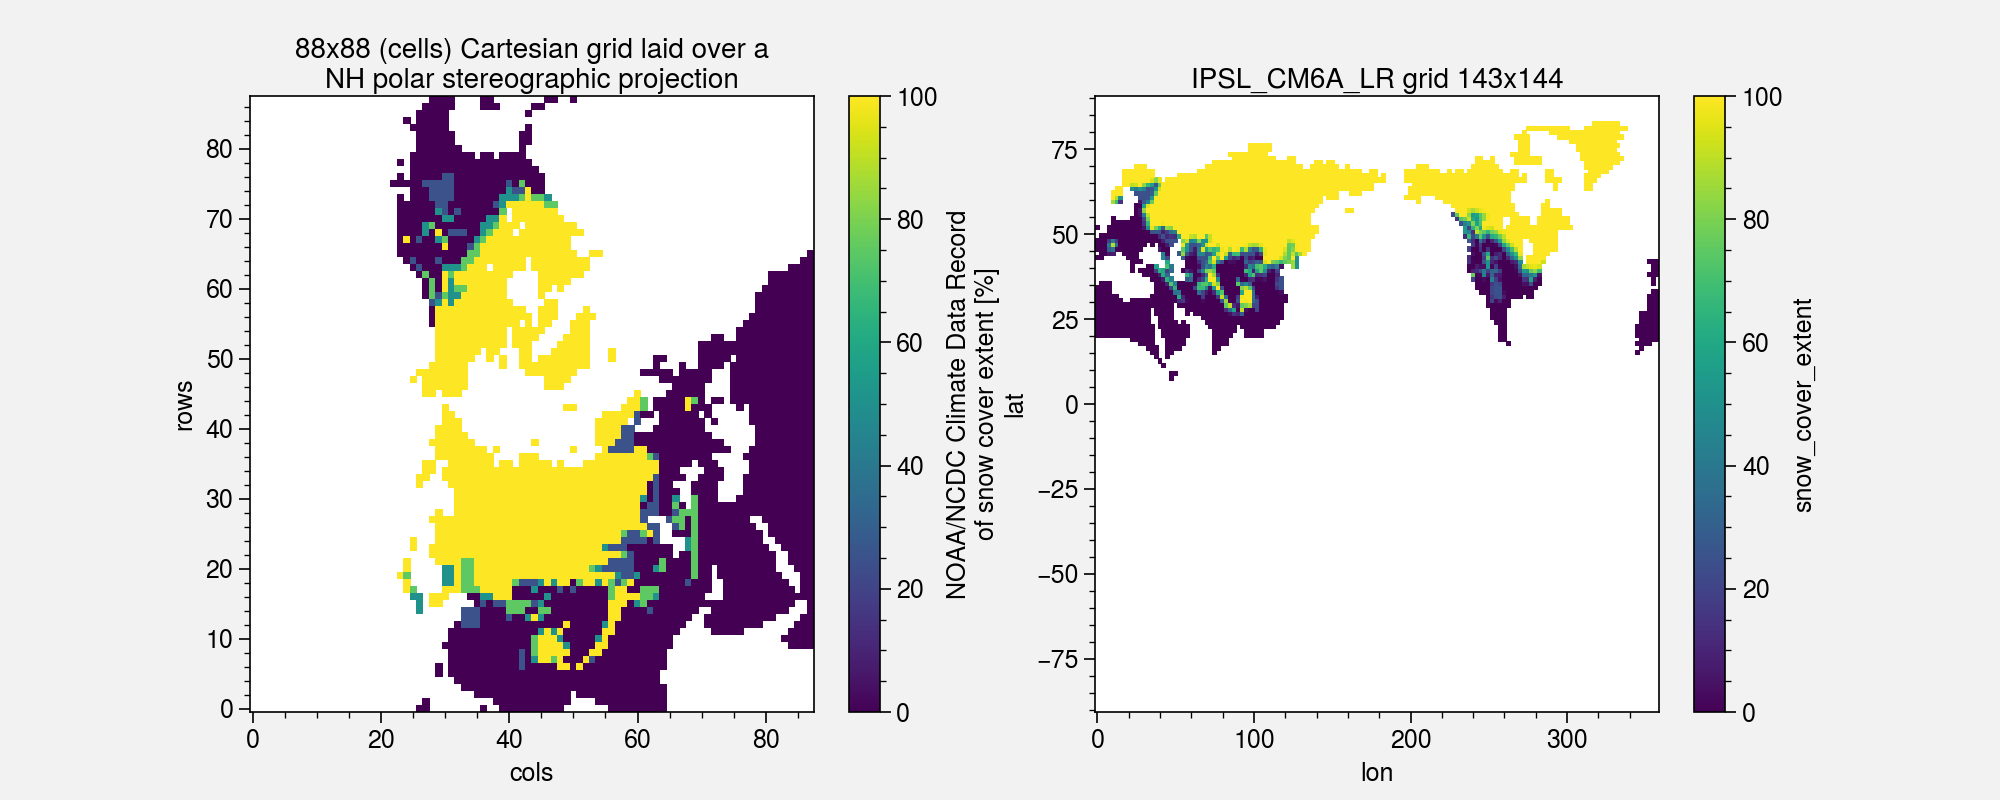

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(121)
obs[0].plot()
plt.title('88x88 (cells) Cartesian grid laid over a\nNH polar stereographic projection')
plt.subplot(122)
obs_regrid[0].plot()
plt.title('IPSL_CM6A_LR grid 143x144')

[#Regrid-HR](#Regrid-HR)

## Other snow dataset
- MERRA-2 (https://disc.gsfc.nasa.gov/datasets/M2TMNXLND_5.12.4/summary?keywords=%22MERRA-2%22%20FRSNO)

In [9]:
da = xr.open_dataarray(
    '/data/mlalande/MERRA-2/MERRA2_100.tavgM_2d_lnd_Nx.198001.nc4.nc4'
)
da

<xarray.DataArray 'FRSNO' (time: 1, lat: 361, lon: 576)>
[207936 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1980-01-01T00:30:00
Attributes:
    long_name:       fractional_area_of_land_snowcover
    units:           1
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]
    origname:        FRSNO
    fullnamepath:    /FRSNO

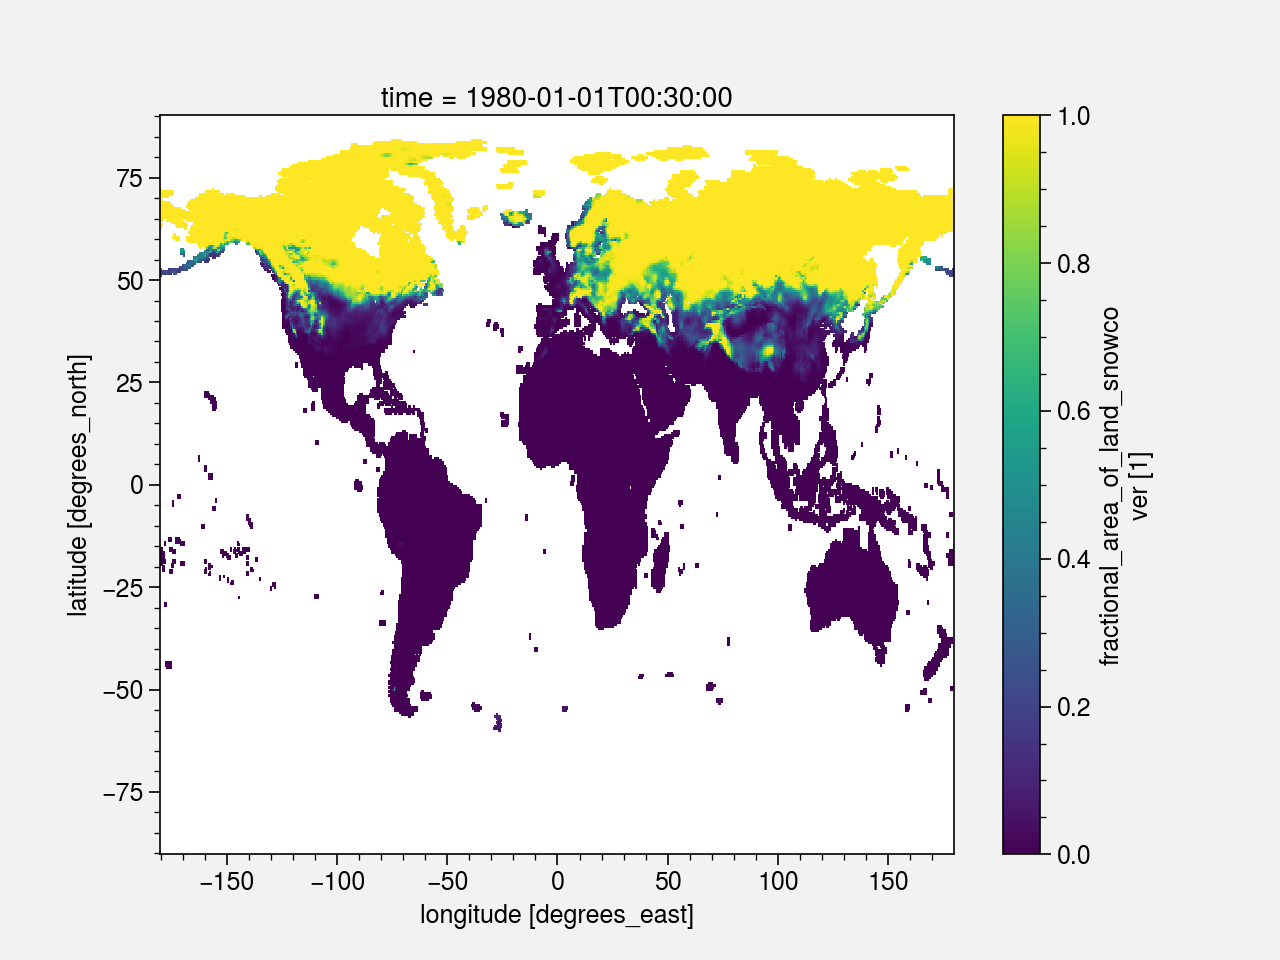

In [10]:
da.plot()

In [45]:
da = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/sd.*.asmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).sd.sel(time=period).load()
sd

<xarray.DataArray 'sd' (time: 408, lat: 241, lon: 480)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.],
        [10., 10., 10., ..., 10., 10., 10.]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float64 0.0 0.75 1.5 2.25 3.0 ... 357.0 357.8 358.5 359.2
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2014-12-01
Attributes:
    long_name:     Snow depth
    units:         m of water equivalent
    num_GRIB:      141
    level_desc:    Surface
    dataset:       Analysis
    actual_range:  [ 0. 10.]

#### Compute snow cover

In [46]:
tmp = 1000*sd/15
sc = tmp.where(tmp<=1, 1)

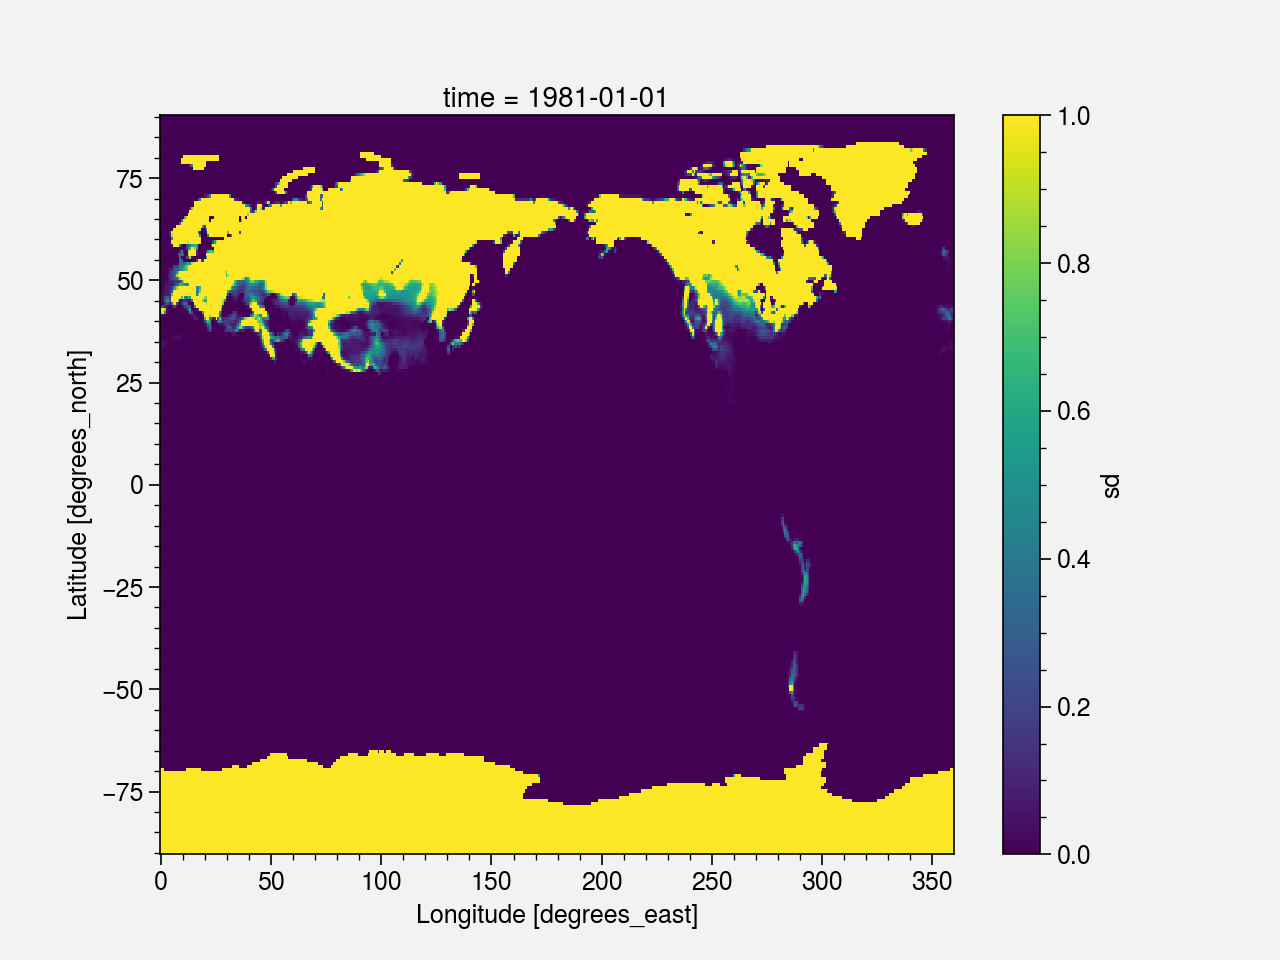

In [48]:
sc[0].plot()

In [49]:
orso = sc.sel(
    lat=slice(latlim[1],latlim[0]), lon=slice(lonlim[0],lonlim[1]), time=slice('2009','2013')
).groupby('time.month').mean('time')
orso

<xarray.DataArray 'sd' (month: 12, lat: 53, lon: 67)>
array([[[1.        , 0.958577  , 0.8571106 , ..., 1.        ,
         1.        , 1.        ],
        [0.80284023, 0.8166367 , 0.76687217, ..., 1.        ,
         1.        , 1.        ],
        [0.60054326, 0.50517577, 0.5528468 , ..., 0.9136652 ,
         0.8540796 , 0.8977879 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[1.        , 1.        , 0.94881135, ..., 1.        ,
         1.        , 1.        ],
        [0.8868734 , 0.829891  , 0.83415526, ..., 1.        ,
         1.        , 1.        ],
        [0.81927335, 0.8061635 , 0.6005895 , ..., 0.9617941 ,
         0.96230257, 0.97922724],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.87953645, 0.93253994, 0.88418686, ..., 1.        ,
         1.        , 0.99194276],
        [0.804129  , 0.6880523 , 0.5710302 , ..., 0.9202139 ,
         0.9176962 , 0.9529866 ],
        [0.54379326, 0.602743  , 0.60135245, ..., 0.86339206,
         0.8401225 , 0.8285767 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       ...,

       [[0.04316966, 0.04796346, 0.03934225, ..., 0.42900902,
         0.3703008 , 0.3992035 ],
        [0.02223969, 0.02427419, 0.02401988, ..., 0.43340045,
         0.4015223 , 0.3889084 ],
        [0.0087738 , 0.00260671, 0.00249227, ..., 0.23629507,
         0.24154663, 0.27295431],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.12565613, 0.11371614, 0.06327311, ..., 0.812822  ,
         0.84640867, 0.89497787],
        [0.08920033, 0.03787994, 0.0197347 , ..., 0.95304567,
         0.8788716 , 0.7701019 ],
        [0.07349651, 0.04327139, 0.05568187, ..., 0.82766116,
         0.792011  , 0.75194395],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.6588954 , 0.56385857, 0.5035736 , ..., 1.        ,
         1.        , 1.        ],
        [0.5936386 , 0.5327352 , 0.456632  , ..., 1.        ,
         1.        , 1.        ],
        [0.52707213, 0.397466  , 0.429039  , ..., 0.95116365,
         0.93290406, 1.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 49.5 48.75 48.0 47.25 46.5 ... 12.75 12.0 11.25 10.5
  * lon      (lon) float64 60.0 60.75 61.5 62.25 ... 107.2 108.0 108.8 109.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Text(0.5, 1.0, 'ERA5 annual mean (2009-2013)')

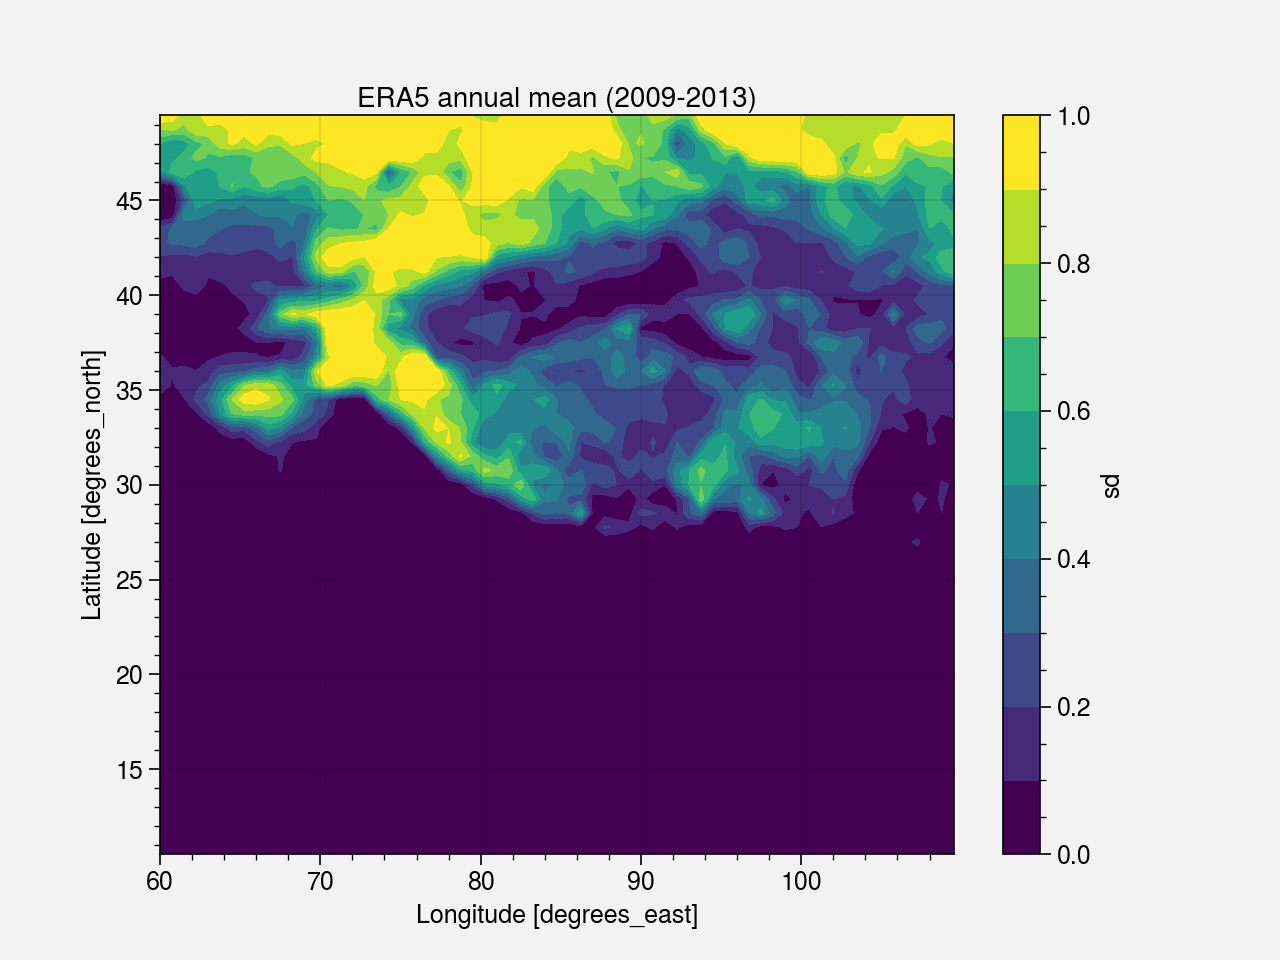

In [53]:
orso.sel(month=1).plot.contourf(levels=11)
plt.title('ERA5 annual mean (2009-2013)')
# plt.savefig('scf_ERA5_annual_mean_2009-2013.pdf')

In [54]:
# Make the regrider
regridder_ERAI = xe.Regridder(sc, da_historical, 'bilinear', periodic=True, reuse_weights=True)
regridder_ERAI

Create weight file: bilinear_241x480_143x144_peri.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_241x480_143x144_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (241, 480) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

In [55]:
# Regrid the data
da_regrid = regridder_ERAI(sc)

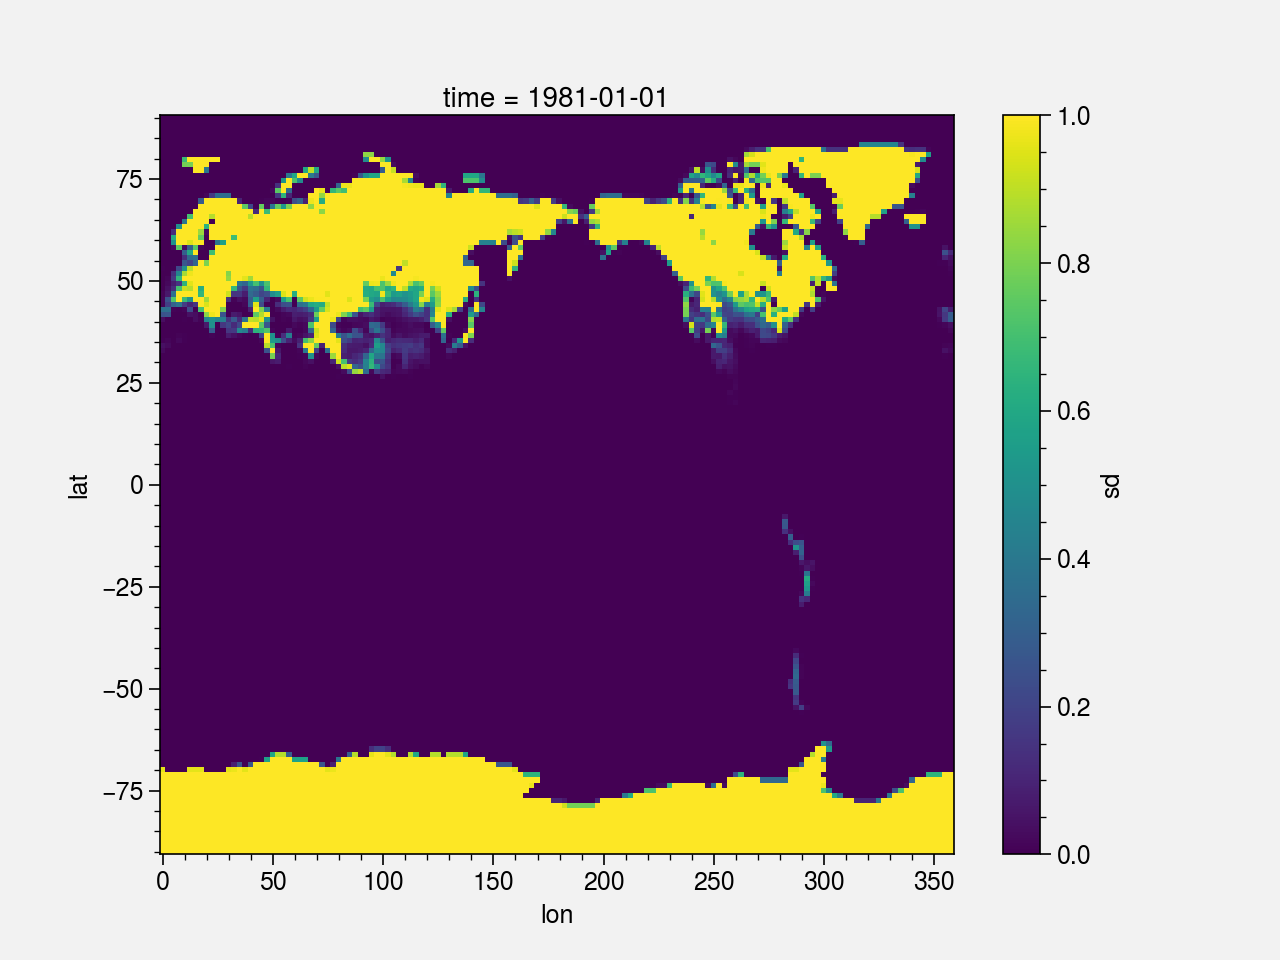

In [56]:
da_regrid[0].plot()

In [57]:
da_regrid_mon = da_regrid.groupby('time.month').mean('time').sel(
    lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])
)
da_regrid_mon

<xarray.DataArray 'sd' (month: 12, lat: 32, lon: 21)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.64709881, 0.88301399, 0.91406121, ..., 0.66049083,
         0.58163557, 0.67317784],
        [0.92397497, 0.94122789, 0.97765247, ..., 0.81454261,
         0.98240388, 0.93035669],
        [0.99502567, 0.97730494, 0.977068  , ..., 0.94350844,
         1.        , 0.99991653]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.67557116, 0.83553961, 0.84976796, ..., 0.598941  ,
         0.53346565, 0.6562796 ],
        [0.94763501, 0.92581336, 0.95910584, ..., 0.74843684,
         0.96760937, 0.96084555],
        [0.99315078, 0.96975735, 0.99040365, ..., 0.91801852,
         0.99818949, 1.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.44992383, 0.42144688, 0.46185305, ..., 0.33008422,
         0.35776968, 0.38236472],
        [0.77130162, 0.70709549, 0.74787054, ..., 0.40864335,
         0.91143285, 0.70736743],
        [0.94164277, 0.90695967, 0.91729395, ..., 0.69122046,
         0.98272602, 0.98756216]],

       ...,

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.00374375, 0.00180748, 0.00272135, ..., 0.09881971,
         0.07569708, 0.07435692],
        [0.00846498, 0.00486764, 0.00698217, ..., 0.11163086,
         0.18540839, 0.21237233],
        [0.01717339, 0.01395371, 0.01604966, ..., 0.13713873,
         0.25233727, 0.37042839]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.07868744, 0.08425453, 0.10755024, ..., 0.31727932,
         0.2796595 , 0.30129196],
        [0.17961489, 0.14182319, 0.15299613, ..., 0.46507005,
         0.58249038, 0.49785673],
        [0.31175036, 0.21187562, 0.23201573, ..., 0.5663069 ,
         0.75266986, 0.78388617]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.49970125, 0.60730519, 0.70867249, ..., 0.54310432,
         0.49331459, 0.57541047],
        [0.82832151, 0.82687511, 0.84673675, ..., 0.67383431,
         0.92014361, 0.78836841],
        [0.90062884, 0.84995273, 0.89574819, ..., 0.84647327,
         0.961848  , 0.96721771]]])
Coordinates:
  * lon      (lon) float32 60.0 62.5 65.0 67.5 70.0 ... 102.5 105.0 107.5 110.0
  * lat      (lat) float32 10.140845 11.408451 12.676056 ... 48.169014 49.43662
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

#### Monthly mean

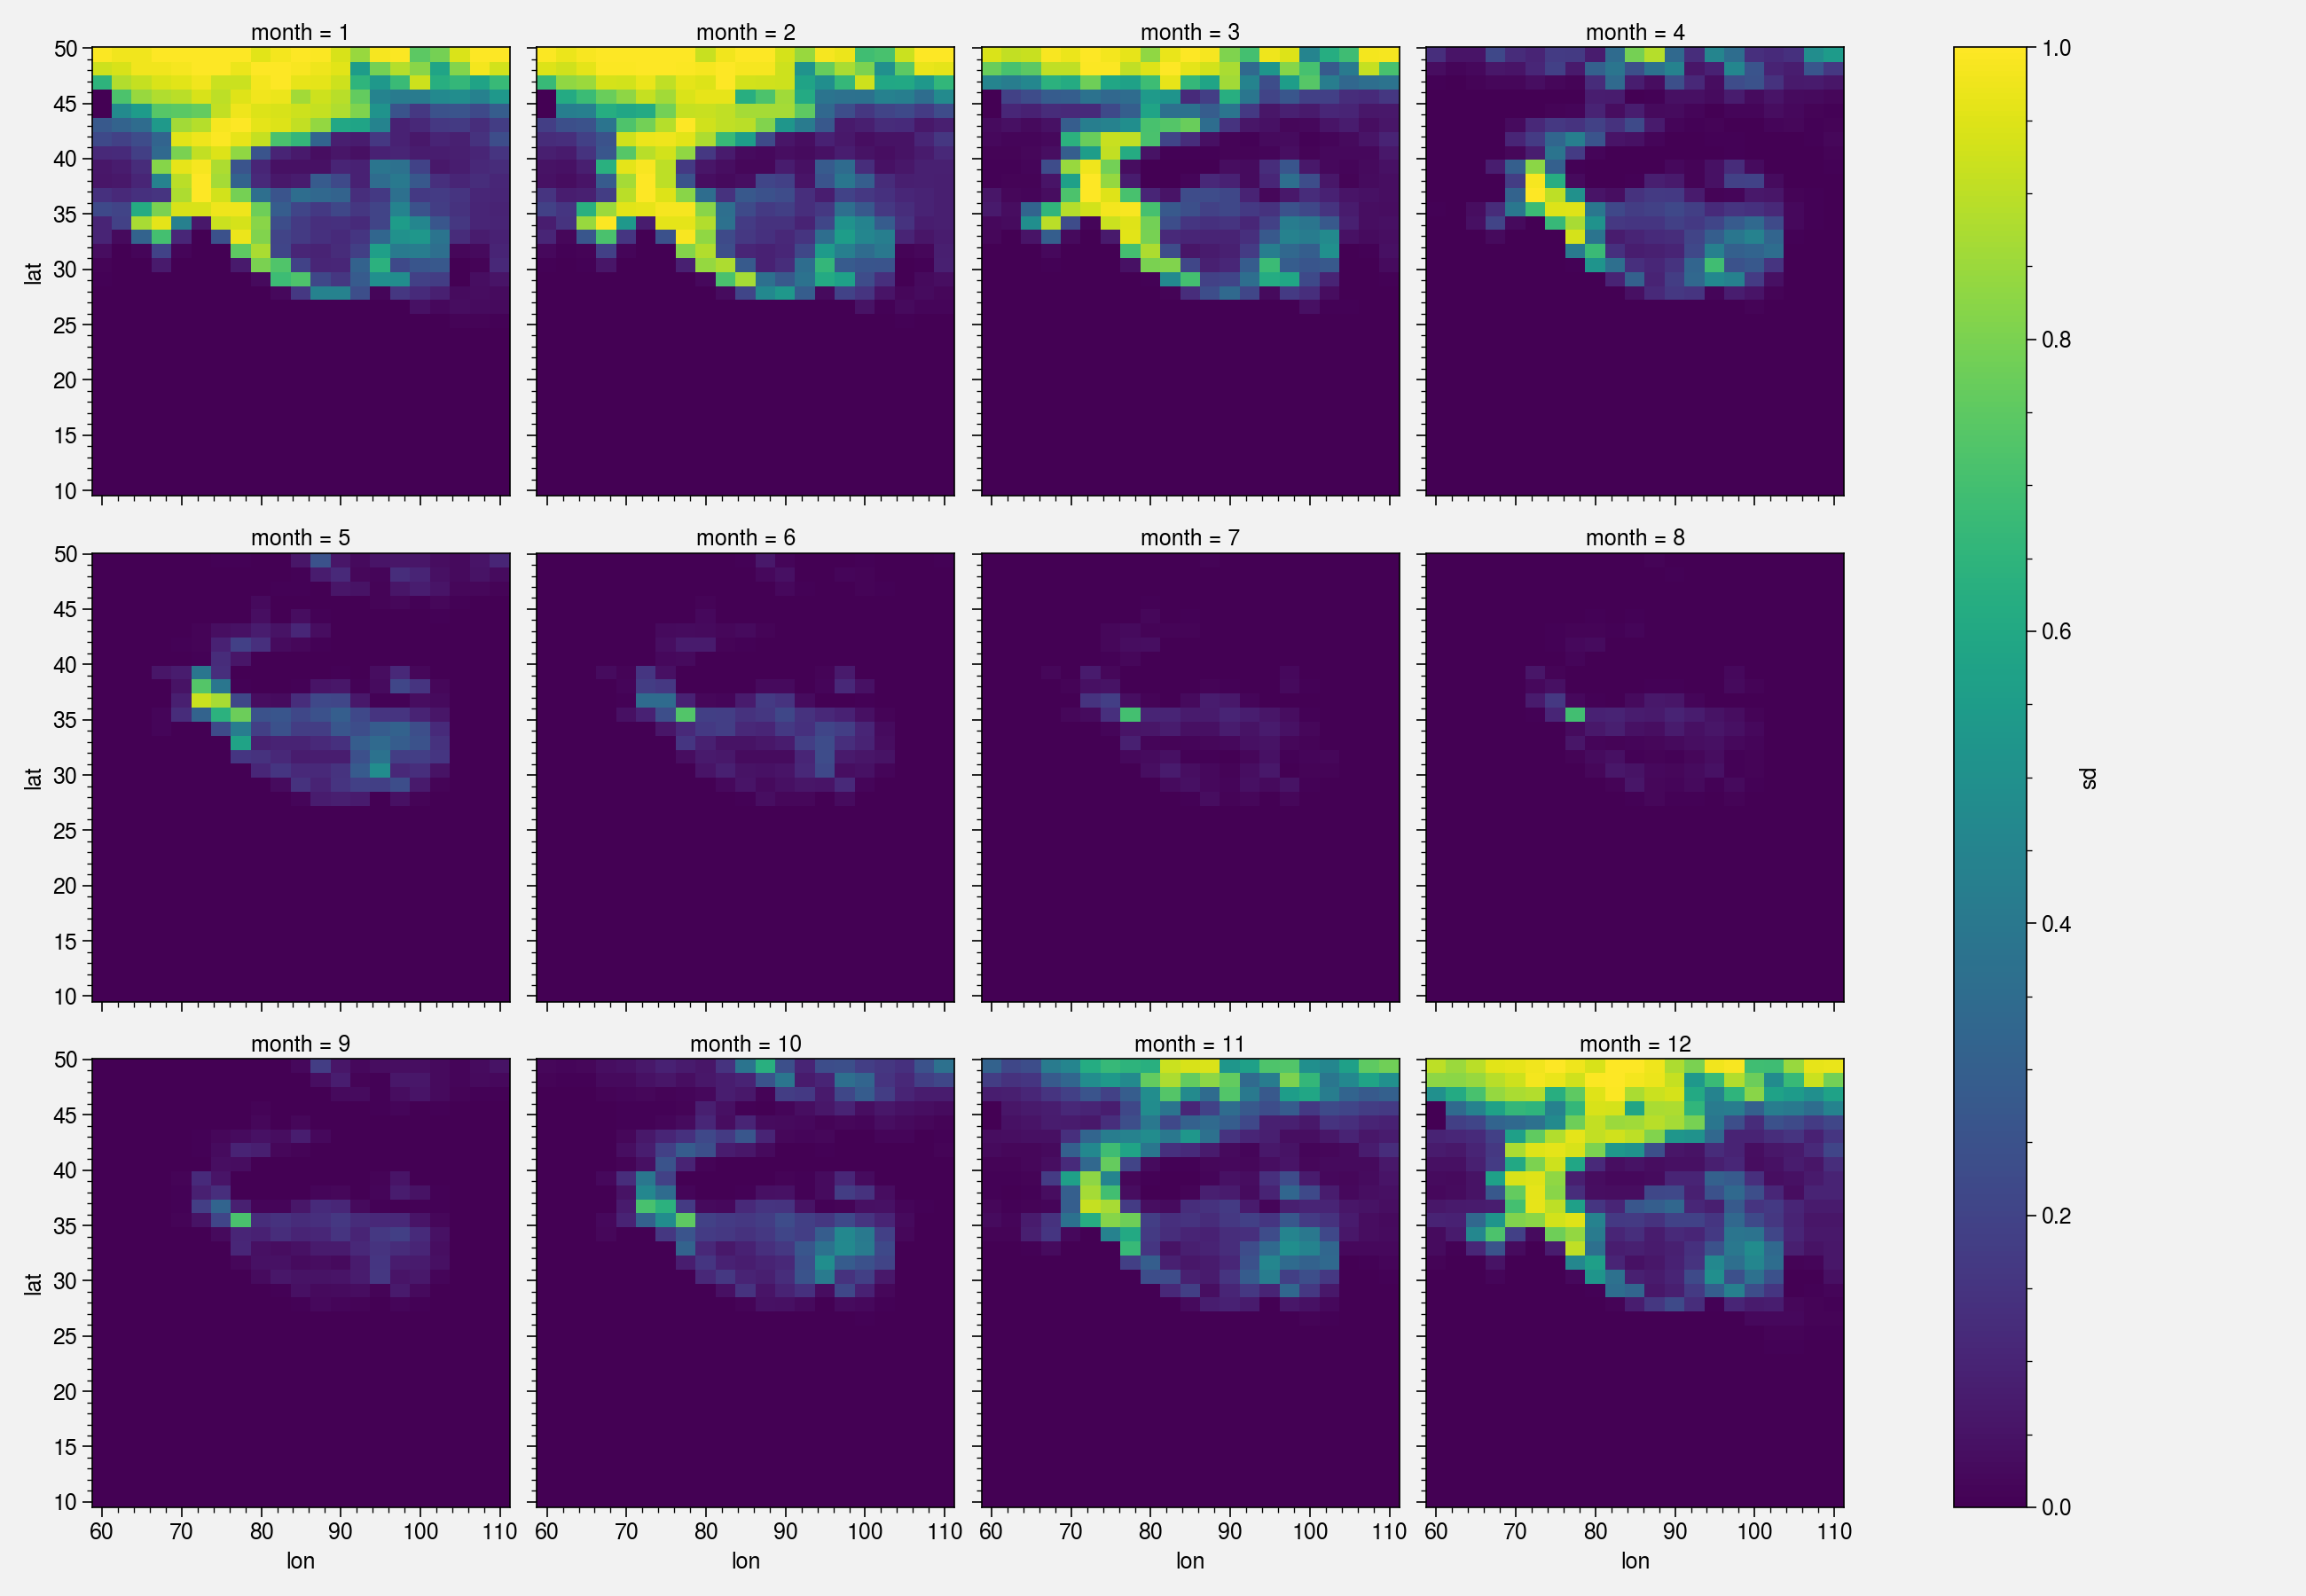

In [58]:
da_regrid_mon.plot(col='month', col_wrap=4, robust=False)

In [59]:
obs_mon = obs_regrid.groupby('time.month').mean('time').sel(
    lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])
)
obs_mon

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'snow_cover_extent' (month: 12, lat: 32, lon: 21)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [9.05357804e+01, 9.42354777e+01, 9.50180349e+01, ...,
         9.58052997e+01, 9.91032245e+01, 9.90550884e+01],
        [9.66370322e+01, 9.78039480e+01, 9.83913729e+01, ...,
         9.90546673e+01, 9.97980191e+01, 9.95964000e+01],
        [9.95587603e+01, 9.96493616e+01, 9.97590857e+01, ...,
         9.96627832e+01, 1.00000000e+02, 9.99210896e+01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [9.25456095e+01, 9.47387287e+01, 9.48952201e+01, ...,
         9.11465398e+01, 9.58502593e+01, 9.55962486e+01],
        [9.94873165e+01, 9.95088338e+01, 9.96923991e+01, ...,
         9.75662112e+01, 9.84607164e+01, 9.61187703e+01],
        [9.99462111e+01, 1.00000000e+02, 1.00000000e+02, ...,
         9.90985270e+01, 9.92399890e+01, 9.83151769e+01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [6.07661717e+01, 5.78338351e+01, 5.97115186e+01, ...,
         4.96786298e+01, 4.89934161e+01, 5.71765516e+01],
        [8.05207755e+01, 7.64073552e+01, 8.13268279e+01, ...,
         6.81166607e+01, 7.70919183e+01, 7.21885201e+01],
        [9.17079630e+01, 8.99192262e+01, 9.09192688e+01, ...,
         7.89370599e+01, 8.57649978e+01, 8.46832292e+01]],

       ...,

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [2.69153659e-01, 6.62153870e-02, 6.56260140e-01, ...,
         1.05917802e+01, 8.71839099e+00, 7.51500019e+00],
        [1.13273813e+00, 6.96777498e-01, 1.02319020e+00, ...,
         1.00989219e+01, 1.30663929e+01, 1.39576677e+01],
        [2.95950497e+00, 1.82315218e+00, 1.89019024e+00, ...,
         7.17715544e+00, 8.51808053e+00, 9.28002127e+00]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [1.44098764e+01, 1.36183685e+01, 1.91069296e+01, ...,
         5.54320645e+01, 3.82771176e+01, 4.46353830e+01],
        [2.31412229e+01, 2.10705603e+01, 2.87964718e+01, ...,
         6.21614834e+01, 5.81717525e+01, 5.69578811e+01],
        [3.71977228e+01, 3.30208770e+01, 3.81513753e+01, ...,
         5.98705631e+01, 6.27529050e+01, 6.29119518e+01]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
   

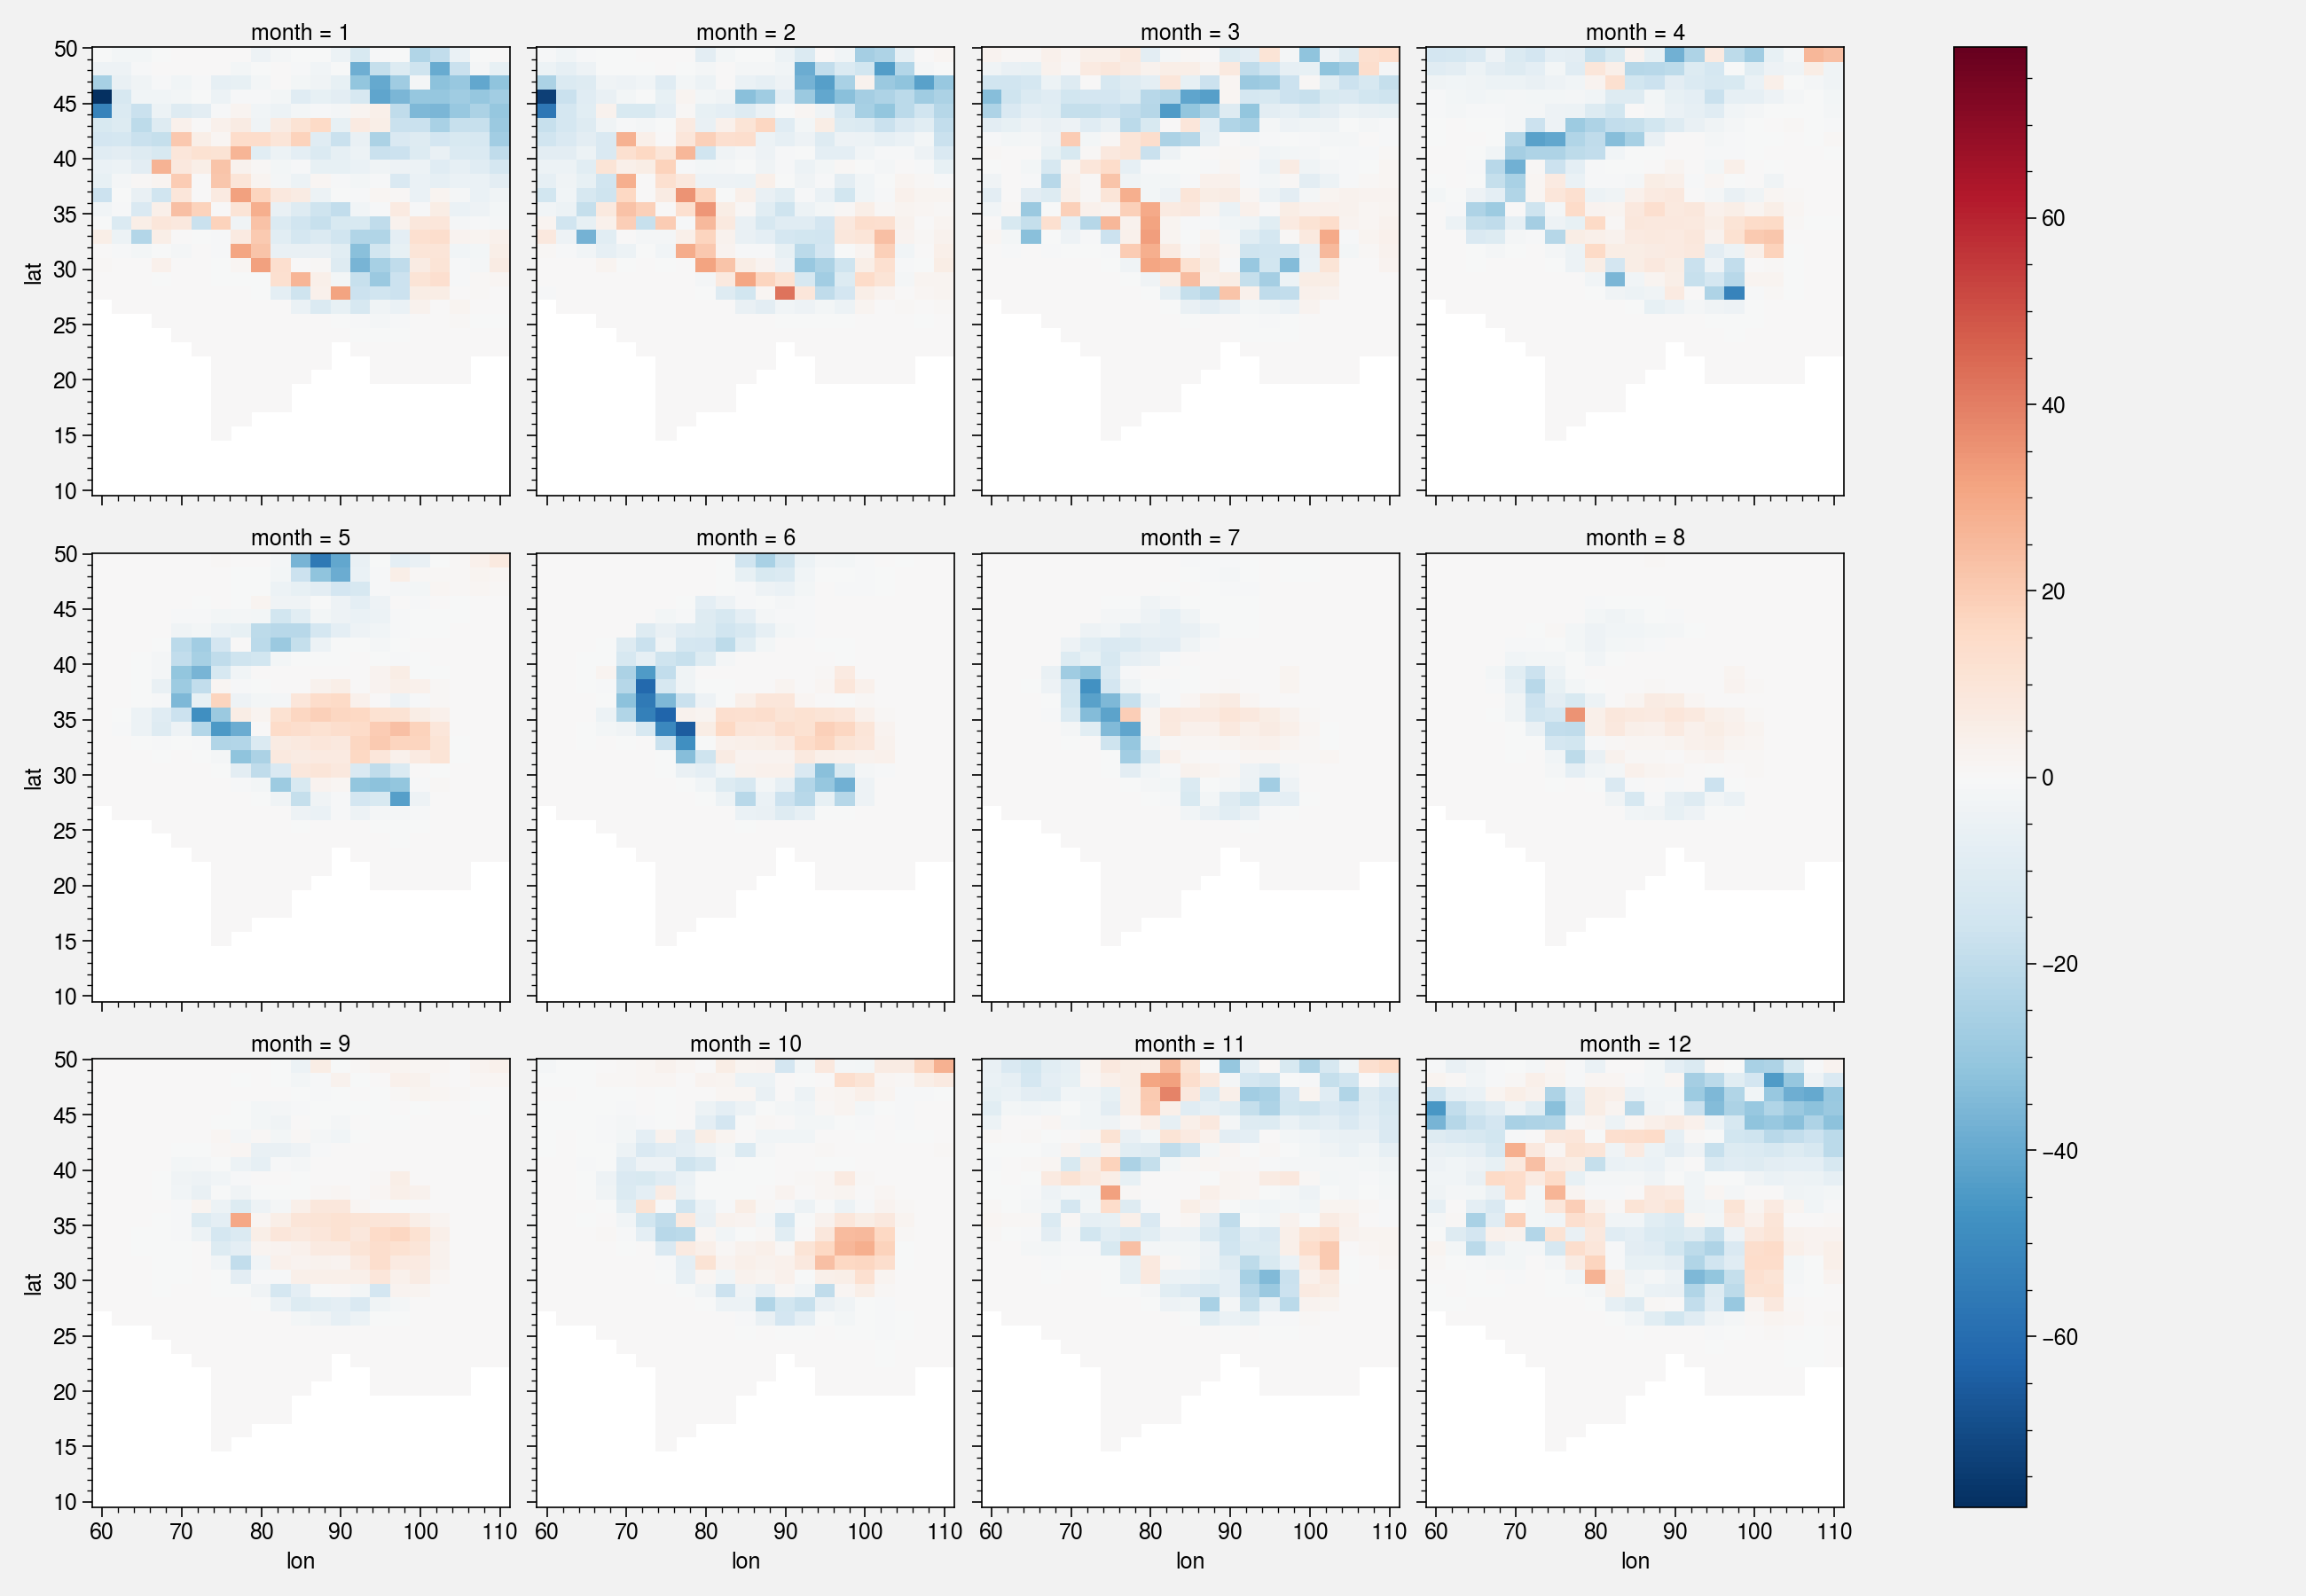

In [61]:
(da_regrid_mon*100-obs_mon).plot(col='month', col_wrap=4, robust=False)

In [62]:
bias = da_regrid_mon.mean('month')*100-obs_mon.mean('month')

In [63]:
bias.min()

<xarray.DataArray ()>
array(-23.05556988)
Coordinates:
    snow_cover_threshold  float32 0.42

In [64]:
bias.max()

<xarray.DataArray ()>
array(14.62015151)
Coordinates:
    snow_cover_threshold  float32 0.42

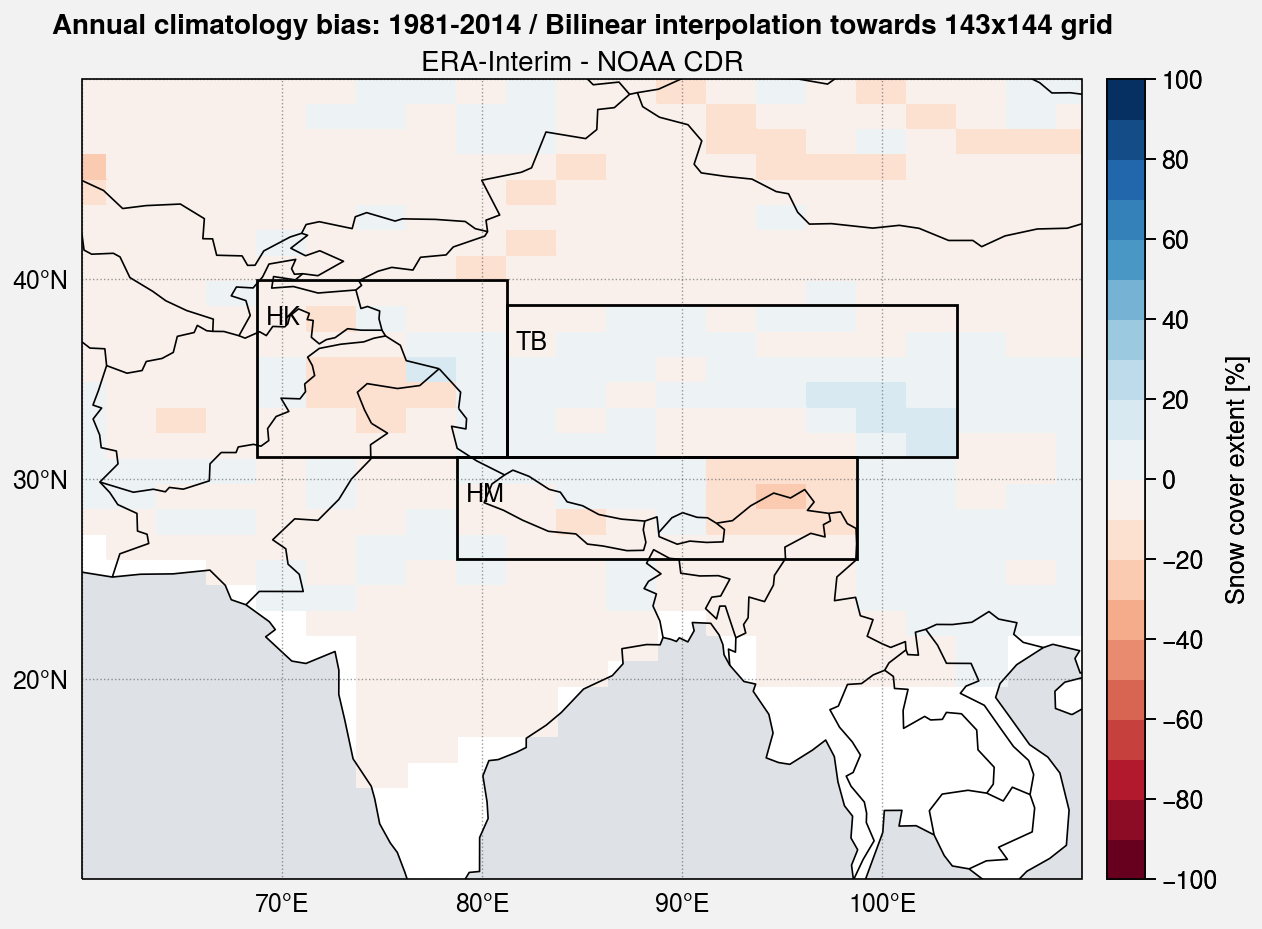

In [67]:
# Final plot

f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, share=3, axwidth=5)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        bias, 
        cmap='RdBu', 
        levels=plot.arange(-100,100,10), 
#         extend='both',
#         norm='midpoint'
    )
    ax.format(title='ERA-Interim - NOAA CDR')

f.colorbar(m, label=var_label)

# Add boxes
for ax in axs:
    u.plot_zones_IPSL_CM6A_LR(ax)

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual climatology bias: 1981-2014 / Bilinear interpolation towards 143x144 grid",
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

f.save('img/'+var+'/'+var+'_ERAI-NOAA_CDR_bias.png')